In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.integrate import quad
from scipy import integrate as intg
import sympy as sp
from scipy import stats
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.stats import linregress
from scipy.stats import norm
import os
import seaborn as sns
from matplotlib import pyplot as plt, patches
#!pip statistics
import statistics


from astropy.table import Table

In [ ]:
#!pip install git+https://github.com/mfouesneau/ezpadova
#import ezpadova

drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#r = ezpadova.get_isochrones(photsys_file='gaiaEDR3', logage=(6, 10, 0.2), MH=(-2, 1, 0.4))

Querying http://stev.oapd.inaf.it/cgi-bin/cmd...
Retrieving data...


# Reading in the Data


In [ ]:
#Open FITS file:
#hdu = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_2_catwise.fits')
#hdu = fits.open('/content/drive/MyDrive/galactic project/Chris and Punya Project/table_2_catwise.fits')
hdu = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_1_catwise.fits')

#/content/drive/MyDrive/Chris and Punya Project/table_2_catwise.fits
#An HDU (Header Data Unit) consist of a header and (typically) a data array or table.

#Check our HDU information, slices and cube:
print(hdu.info())
header = hdu[0].header

data = hdu[1].data
print(data.columns)


print(list(header.keys()))




Filename: /content/drive/MyDrive/Chris and Punya Project/table_1_catwise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   174922161R x 7C   [K, D, D, L, D, D, D]   
None
ColDefs(
    name = 'source_id'; format = 'K'
    name = 'catwise_w1'; format = 'D'
    name = 'catwise_w2'; format = 'D'
    name = 'in_training_sample'; format = 'L'
    name = 'mh_xgboost'; format = 'D'
    name = 'teff_xgboost'; format = 'D'
    name = 'logg_xgboost'; format = 'D'
)
['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND']


In [ ]:

# --- PERFORM THE CUT ---
#below would be for table 2, where we have a lot more columns
#cols = ["source_id", "ra", "dec", "parallax",'phot_rp_mean_mag','phot_bp_mean_mag','parallax_error' ,"phot_g_mean_mag",'logg_xgboost','l','b','ra','dec']
#df = pd.DataFrame({c: data[c] for c in cols})
#df.head()
DATA = data[:1000000]
cols = ["source_id",'mh_xgboost','teff_xgboost' ,"logg_xgboost"]
df = pd.DataFrame({c: DATA[c] for c in cols})
df.head()

# Function to fix byte order compatible with NumPy 2.0
def fix_bytes(arr):
    # 1. Swap the bytes (Big -> Little)
    swapped = arr.byteswap()
    # 2. View it with the correct little-endian dtype
    return swapped.view(swapped.dtype.newbyteorder('<'))

df = pd.DataFrame({
    c: fix_bytes(data[c])
    for c in cols
})
#df['absolutemagnitude'] = df['logg_xgboost'] - 5 * np.log10(1000 / df['parallax']) + 5
df2 = df[
    (df['logg_xgboost']  <= 4.15)
    & (df['logg_xgboost'] >= 3.6)

]











print(f"Rows before cut: {len(data):.2e}")
print(f"Rows after cut: {len(df2):.2e}")


print(f"Min Mag: {df2['phot_g_mean_mag'].min():.2f}")


print(list(header.keys()))

In [ ]:
print (hdu)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7e1fb1b736e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7e1fb19a61b0>]


In [ ]:

bp = df2["phot_bp_mean_mag"]
rp = df2["phot_rp_mean_mag"]
g  = df2["phot_g_mean_mag"]
par = df2["parallax"]
abs_g = df2['absolutemagnitude']
#dist = 1000 / par
#abs_g = g - 5 * np.log10(dist) + 5
print (abs_g.max())
plt.figure(figsize=(6,8))
#plt.scatter(bp - rp, abs_g, s=1, alpha=0.3)
plt.hexbin(bp - rp, abs_g, cmap='gist_heat',gridsize=200, mincnt=1,bins='log')

plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()


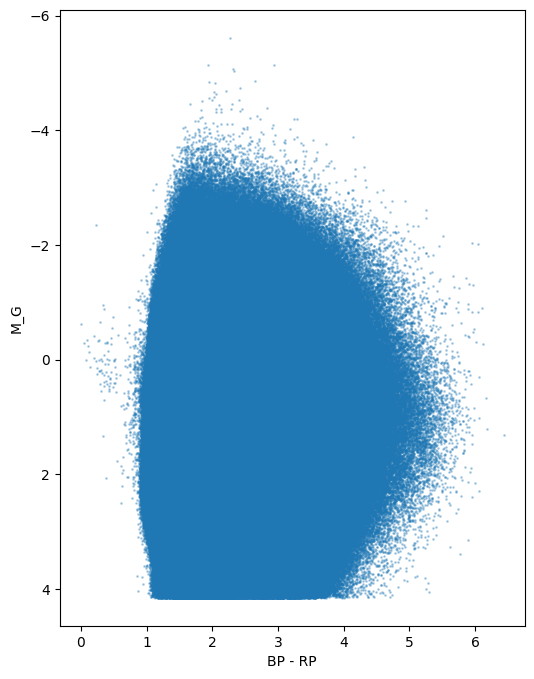

In [ ]:

plt.figure(figsize=(6,8))
plt.scatter(bp - rp, abs_g, s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()


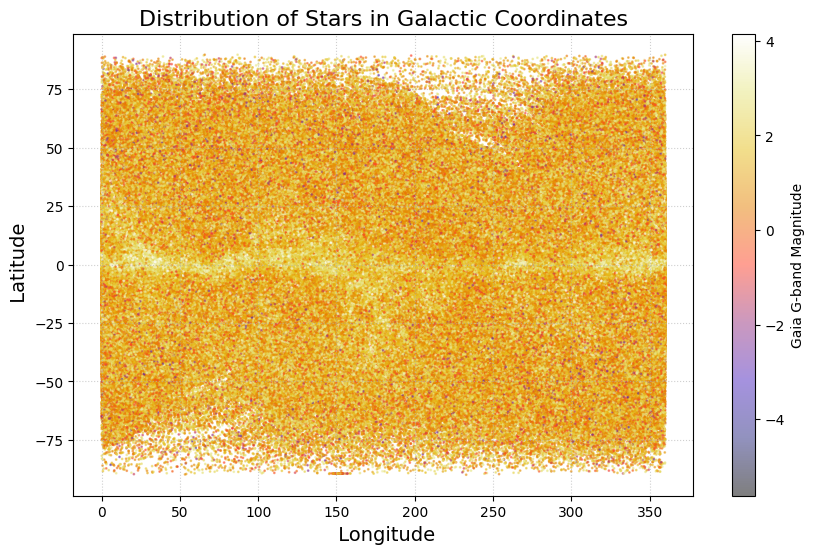

In [ ]:
# Assuming 'data' is the BinTableHDU data (data = hdul[1].data)
n_samples = 10000000
df_sample = df2.sample(n=min(len(df2), n_samples), random_state=42)

l = df_sample['l']
b = df_sample['b']


plt.figure(figsize=(10, 6))
plt.scatter(l, b,
            c=df_sample['absolutemagnitude'], # Color by G magnitude
            s=1,          # Small marker size
            cmap='CMRmap',
            alpha=0.5)

plt.colorbar(label='Gaia G-band Magnitude', cmap = 'CMRmap')
plt.xlabel(' Longitude', fontsize=14)
plt.ylabel(' Latitude', fontsize=14)
plt.title('Distribution of Stars in Galactic Coordinates', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

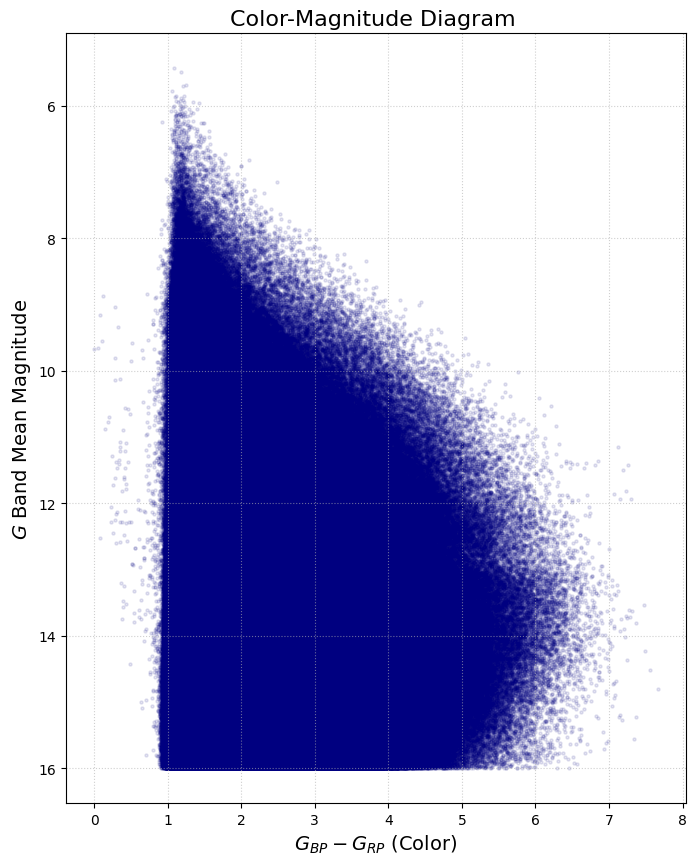

In [ ]:
# Assuming 'data' is the BinTableHDU data
g_mag = data['phot_g_mean_mag']
bp_mag = data['phot_bp_mean_mag']
rp_mag = data['phot_rp_mean_mag']

# Calculate the color index
color_index = bp_mag - rp_mag

# Select a manageable number of stars if the full 17 million is too slow
plt.figure(figsize=(8, 10))
plt.scatter(color_index, g_mag,
            s=5,
            c='navy',
            alpha=0.1)
# Use a 2D histogram (hist2d) for better density visualization on such a large dataset
# plt.hist2d(color_index[idx], g_mag[idx], bins=(100, 100), cmap='plasma')

plt.gca().invert_yaxis() # Conventionally, brighter (smaller magnitude) is at the top
plt.xlabel('$G_{BP} - G_{RP}$ (Color)', fontsize=14)
plt.ylabel('$G$ Band Mean Magnitude', fontsize=14)
plt.title('Color-Magnitude Diagram ', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3368485108.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Proper Motion in RA ($\mu_{\\alpha}$ cos $\\delta$) [mas/yr]', fontsize=14)
/tmp/ipython-input-3368485108.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Proper Motion in Dec ($\mu_{\\delta}$) [mas/yr]', fontsize=14)


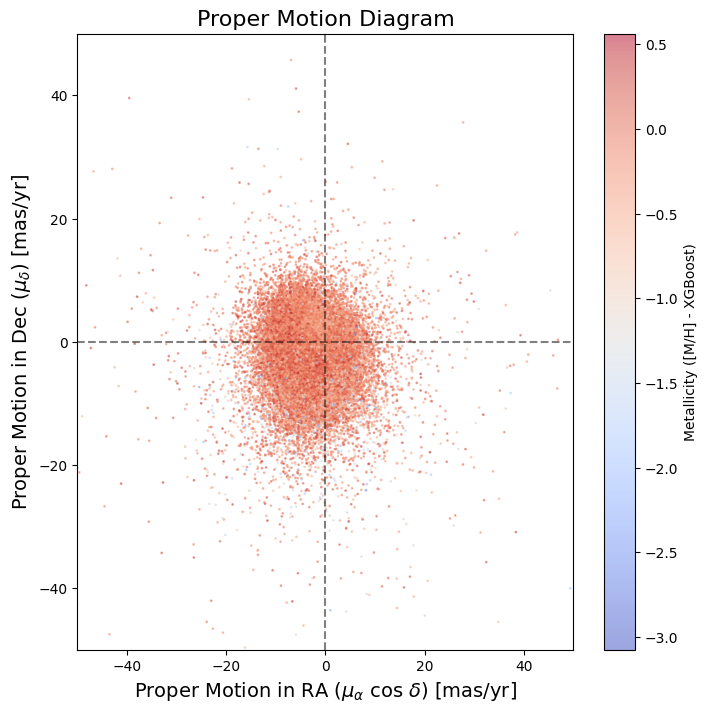

In [ ]:
# Assuming 'data' is the BinTableHDU data
pmra = data['pmra']
pmdec = data['pmdec']
mh = data['mh_xgboost']

# Select a manageable number of stars
N_stars = 100000
idx = np.random.choice(len(pmra), N_stars, replace=False)

plt.figure(figsize=(8, 8))
plt.scatter(pmra[idx], pmdec[idx],
            c=mh[idx], # Color by metallicity
            s=1,
            cmap='coolwarm',
            alpha=0.5)

plt.colorbar(label='Metallicity ([M/H] - XGBoost)')
plt.xlabel('Proper Motion in RA ($\mu_{\\alpha}$ cos $\\delta$) [mas/yr]', fontsize=14)
plt.ylabel('Proper Motion in Dec ($\mu_{\\delta}$) [mas/yr]', fontsize=14)
plt.title('Proper Motion Diagram', fontsize=16)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.xlim(-50, 50) # Zoom in to the main population
plt.ylim(-50, 50)
plt.show()



```
# This is formatted as code
```

# Isochrones


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 1. Define your file paths
file1_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-2to-1.5.dat'
file2_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1.5to-1.dat'
file3_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-1to-0.5.dat'
file4_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone-0.5to0.dat'
file5_path = '/content/drive/MyDrive/Chris and Punya Project/isochrone0to0.5.dat'


# 2. Helper function to read the tricky PARSEC/MIST format
def read_isochrone(filepath):
    """
    Reads an isochrone file, finding the header line automatically
    even if it starts with '#'.
    """
    # First, find the header line inside the file
    with open(filepath, 'r') as f:
        for line in f:
            # We look for a unique column name like 'logAge' or 'Zini'
            if 'logAge' in line:
                # Remove '#', strip whitespace, and split into a list
                col_names = line.replace('#', '').strip().split()
                break

    # Now read the data using those column names
    df = pd.read_csv(
        filepath,
        sep='\s+',       # Reads whitespace-separated data
        comment='#',     # Skips the comment lines during data reading
        header=None,     # We supply headers manually
        names=col_names  # Use the names we found
    )
    return df

# 3. Load both files
iso_df1 = read_isochrone(file1_path)
iso_df2 = read_isochrone(file2_path)
iso_df3 = read_isochrone(file3_path)
iso_df4 = read_isochrone(file4_path)
iso_df5 = read_isochrone(file5_path)

# 4. Combine them into one
master_iso_df = pd.concat([iso_df1, iso_df2, iso_df3, iso_df4, iso_df5], ignore_index=True)

# 5. Verify the combination
print(f"File 1 shape: {iso_df1.shape}")
print(f"Combined shape: {master_iso_df.shape}")

# Optional: Sort by age so the data is continuous
master_iso_df = master_iso_df.sort_values(by=['logAge', 'Mass'])
master_iso_df.head()

<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1374363823.py:29: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',       # Reads whitespace-separated data


File 1 shape: (67034, 37)
File 2 shape: (65351, 37)
Combined shape: (348661, 37)


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,mbolmag,Gmag,G_BPbrmag,G_BPftmag,G_RPmag,B_Tmag,V_Tmag,Jmag,Hmag,Ksmag
12001,0.000196,-1.90,8.0,0.090314,1.084689,0.09,-2.559,3.5554,5.126,0,...,11.166,11.603,12.593,12.630,10.618,14.357,12.602,9.378,8.910,8.770
18014,0.000220,-1.85,8.0,0.090000,1.081690,0.09,-2.565,3.5521,5.117,0,...,11.182,11.638,12.648,12.684,10.643,14.449,12.659,9.384,8.912,8.770
24119,0.000246,-1.80,8.0,0.090000,1.081690,0.09,-2.569,3.5488,5.108,0,...,11.191,11.667,12.697,12.734,10.662,14.534,12.711,9.386,8.908,8.764
30219,0.000276,-1.75,8.0,0.090000,1.081690,0.09,-2.573,3.5455,5.099,0,...,11.201,11.698,12.749,12.785,10.683,14.621,12.764,9.388,8.903,8.758
36338,0.000310,-1.70,8.0,0.090000,1.081690,0.09,-2.577,3.5422,5.090,0,...,11.212,11.729,12.802,12.837,10.704,14.708,12.819,9.391,8.899,8.752


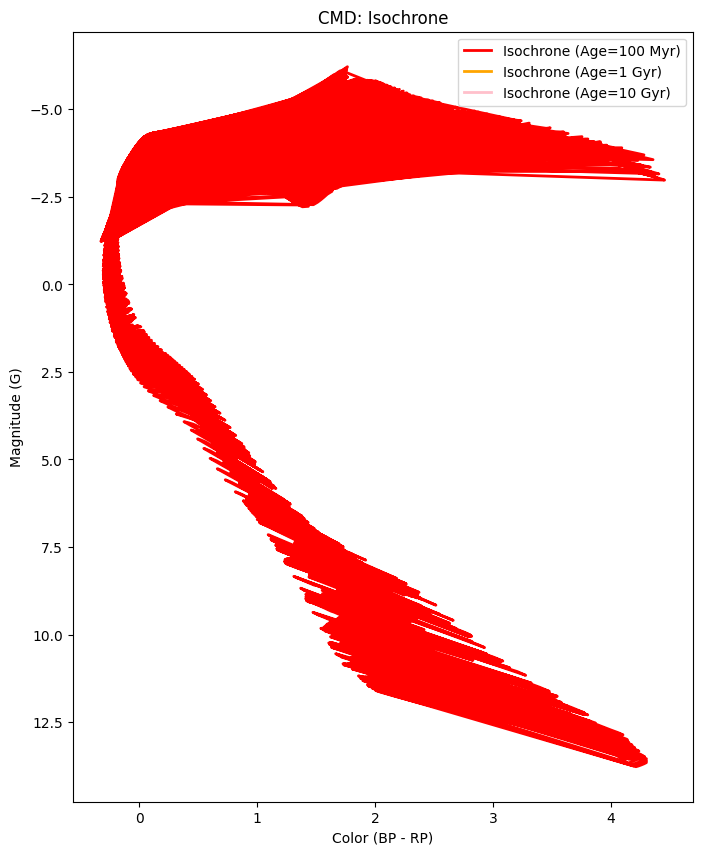

In [ ]:
# Create Color and Magnitude columns for plotting
plt.figure(figsize=(8, 10))

# If Gmag is brighter (less) than 10.87, use 'br'. Otherwise, use 'ft'.
master_iso_df['BP_actual'] = np.where(
    master_iso_df['Gmag'] < 10.87,
    master_iso_df['G_BPbrmag'],
    master_iso_df['G_BPftmag'])
master_iso_df['BP_RP'] = master_iso_df['BP_actual'] - master_iso_df['G_RPmag']
master_iso_df['M_G'] = master_iso_df['Gmag']

# You often have many ages in one file. Filter for the specific age you want.
# Example: Select logAge = 8.0 (100 Million years)
one_iso8 = master_iso_df[master_iso_df['logAge'] == 8.0]

plt.plot(one_iso8['BP_RP'], one_iso8['M_G'],
         color='red', linewidth=2, label='Isochrone (Age=100 Myr)')
# Example: Select logAge = 9.0 (1 Billion years)
one_iso9 = master_iso_df[master_iso_df['logAge'] == 9.0]

plt.plot(one_iso9['BP_RP'], one_iso9['M_G'],
         color='orange', linewidth=2, label='Isochrone (Age=1 Gyr)')
# Example: Select logAge = 10.0 (10 Billion years)
one_iso10 = master_iso_df[master_iso_df['logAge'] == 10.0]

plt.plot(one_iso10['BP_RP'], one_iso10['M_G'],
         color='pink', linewidth=2, label='Isochrone (Age=10 Gyr)')

# --- Formatting the Graph ---
plt.gca().invert_yaxis()  # Magnitudes are reverse (brighter is lower number)
plt.xlabel('Color (BP - RP)')
plt.ylabel('Magnitude (G)')
plt.legend()
plt.title('CMD: Isochrone')

plt.show()

Big Data

In [ ]:

# Define the filename
file_path1 = '/content/drive/MyDrive/galactic project/Chris and Punya Project/table_1_catwise.fits'

print("Reading FITS file... (this may take a moment)")
# Read the FITS file using astropy
# 'memmap=True' helps avoid loading the entire file into RAM at once during the read step
astro_table1 = Table.read(file_path1, format='fits', memmap=True)

# Convert to a pandas DataFrame for easier analysis
df1 = astro_table1.to_pandas()

print(f"\nSuccessfully loaded {len(df1)} stars.")
df1.head()

Reading FITS file... (this may take a moment)

Successfully loaded 174922161 stars.


,source_id,catwise_w1,catwise_w2,in_training_sample,mh_xgboost,teff_xgboost,logg_xgboost
0,4295806720,15.796,15.942,False,-0.256,5991.6,4.551
1,38655544960,11.837,11.879,False,-0.212,4791.6,4.604
2,1275606125952,14.366,14.438,False,-0.438,5177.3,4.489
3,1653563247744,14.734,14.802,False,-1.286,6102.0,4.017
4,2851858288640,10.904,10.932,True,-0.454,5899.5,4.295
